<a href="https://colab.research.google.com/github/margheritacrn/HighwayEnv/blob/master/ExperienceReplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install highway-env
!pip install gymnasium
import gymnasium as gym
import highway_env
#import DQN
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 19.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
env = gym.make('highway-fast-v0', render_mode='rgb_array')
"""config = {
            "observation": {
                "type": "Kinematics",
                "vehicles_count": 50,
                "features": ["presence","x","y","vx","vy","cos_h","sin_h"],
                "features_range": {
                    "x": [-100, 100],
                    "y": [-100, 100],
                    "vx": [-30, 30],
                    "vy": [-30, 30]
                },
                "order": "sorted",
                "absolute": False,
                "normalize": True,
                "clip": True
                },
            "action": {
                "type": "DiscreteMetaAction",
            },
            "lanes_count": 4,
            "controlled_vehicles": 1,
            "initial_lane_id": None,
            "duration": 60,  # [s]
            "ego_spacing": 1.5,
            "vehicles_density": 1,
            "collision_reward": -1,    # The reward received when colliding with a vehicle.
            "right_lane_reward": 0.1,  # The reward received when driving on the right-most lanes, linearly mapped to
                                       # zero for other lanes.
            "high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
            "lane_change_reward": 0,   # The reward received at each lane change action.
            "reward_speed_range": [20, 30],
            "normalize_reward": True,
            "offroad_terminal": False,
            "screen_width": 1080,
            "screen_height": 480,
        }
env.configure(config)"""

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


'config = {\n            "observation": {\n                "type": "Kinematics",\n                "vehicles_count": 50,\n                "features": ["presence","x","y","vx","vy","cos_h","sin_h"],\n                "features_range": {\n                    "x": [-100, 100],\n                    "y": [-100, 100],\n                    "vx": [-30, 30],\n                    "vy": [-30, 30]\n                },\n                "order": "sorted",\n                "absolute": False,\n                "normalize": True,\n                "clip": True\n                },\n            "action": {\n                "type": "DiscreteMetaAction",\n            },\n            "lanes_count": 4,\n            "controlled_vehicles": 1,\n            "initial_lane_id": None,\n            "duration": 60,  # [s]\n            "ego_spacing": 1.5,\n            "vehicles_density": 1,\n            "collision_reward": -1,    # The reward received when colliding with a vehicle.\n            "right_lane_reward": 0.1,  #

In [3]:
#Idee-->classe per il buffer+classe per la network+ classe finale con metodo train 
# Environment
import numpy as np
import tensorflow as tf

class buffer(object):
    def __init__(self, size):
        self.size=size
        #self.buffer_= np.zeros((self.size))#each row contains: state,action,reward,next_state,done
        self.buffer_=[]
        #self.last_filled_row=-1
    def sample(self,n: int):
        "The methods samples n tuples s,a,r,s_next, done"
        random_rows=np.random.choice(len(self.buffer_),n, replace=False) #cosa faccio se pesco 0? forse non arrivo mai senza buffer riempito
        return [self.buffer_[i] for i in random_rows]
    def store_episode(self,s,a,r,s_next,done):
        #self.last_filled_row+=1
        #print( self.buffer_.shape)
        if(len(self.buffer_)>self.size):
             self.buffer_.pop()
        #self.buffer_[self.last_filled_row,:]=np.array([s,a,r,s_next,done])
        self.buffer_.append([s,a,r,s_next,done])
    
class QN(object):
    def __init__(self, action_space, observation_space):
        self.action_space = action_space
        self.observation_space = observation_space
        self.model = tf.keras.models.Sequential([
            tf.keras.Input(shape=observation_space.shape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(action_space.n),
        ])
        loss = tf.keras.losses.MeanSquaredError()
        self.model.compile(
            optimizer='adam',
            loss=loss
        )

    def predict(self, states):
        """
        Takes a batch of states and returns the current value predictions for all their actions
        :param states:
        :return:
        """
        states = np.asarray(states)
        return self.model.predict(states)

    def fit(self, states, action_values):
        """
        Fits a batch of states and a matrix of value predictions, returns the errors for each tuple
        :param states:
        :param action_values:
        :return:
        """
        states = np.asarray(states)
        action_values = np.asarray(action_values)
        return self.model.train_on_batch(states, action_values)


class DQNet(object):
    """DQN with experience reply, NOT prioritized"""
    def __init__(self, env):
        self.env = env
        self.nn = QN(self.env.action_space, self.env.observation_space)

        self.eps_0= 1.0
        self.eps = self.eps_0
        self.eps_decay = 0.999
        self.eps_min = 0.05 #lowest exploration rate
        self.buffer_size=15000
        self.batch_size=32
        self.gamma = 0.8
        self.train_rewards = [] #to visualize how they change during the training phase.
        self.buffer_=buffer(self.buffer_size)

    def sample_action(self, q_values):
            if np.random.random() <= self.eps:
                return self.env.action_space.sample()
            else:
                return self.get_greedy_action(q_values=q_values)

    def get_greedy_action(self, s=None, q_values=None):
            if q_values is None:
                q_values = self.nn.predict([s])
            #return np.argmax(q_values) #il problema è che questo non ritorna l'azione perché qvalues è una matrice (5,5)
            return np.where(q_values==np.max(q_values))[0][0]

    def compute_target_value(self, s, a, r, s2, done, type='QL'):
            g = r
            if not done and type=='QL':
                g += self.gamma * np.max(self.nn.predict([s2])[0])
            if not done and type=='SARSA': #mia aggiunta 
                g+=self.gamma*self.nn.predict([s2])[0][self.sample_action(self.nn.predict([s2])[0])]
            return g
        
    def train(self, steps=1000, type='QL'): #steps will always be self.batch_size
            self.eps = self.eps_0
            self.train_rewards = []

            i = 0
            while i < steps:
                done = False
                s = self.env.reset()[0]
                r_collect = 0
                ep_i = 0
                while not done:
                    q_values = self.nn.predict([s])[0] #shape (5,5)
                    #print(self.nn.predict([s])[0].shape, self.nn.predict([s]).shape)
                    a = self.sample_action(q_values)
                    print(a) ###
                    s2, r, done,truncated, _ = self.env.step(a)
                    r_collect += r
                    i += 1
                    ep_i += 1
                    self.buffer_.store_episode(s,a,r,s2,done)
                    self.eps = max(self.eps_min, self.eps * self.eps_decay)
                    s = s2
                    if done or truncated :
                        break
                    elif(i>self.batch_size):
                        batch_sample=self.buffer_.sample(self.batch_size) #collecting the tuples for the training step, each row contains: state,reward,action,next_state,done
                        for t in batch_sample:
                            if(t[4]):
                                continue
                            target_value = self.compute_target_value(t[0], t[1], t[2], t[3], t[4], type) 
                            q_values[t[1]] = target_value
                            self.nn.fit([t[0]], [q_values])
                        
                ######
                self.train_rewards.append(r_collect)
                print(self.train_rewards)
                
                print(f"Episode done, step {i}")
    def get_prediction(self,states):
      return self.nn.predict(states)
    def get_tot_rewards(self):
        return self.train_rewards


In [4]:
dqn=DQNet(env)

In [11]:
(obs, info), done = env.reset(), False
while not done:
        q_values=dqn.get_prediction(obs)
        action= np.where(q_values==np.max(q_values))[0][0]
        print(action)
        obs, reward, done, truncated, info = env.step(int(action))

1/1 [==============================] - 0s 132ms/step
2
1/1 [==============================] - 0s 37ms/step
2
1/1 [==============================] - 0s 47ms/step
2


In [5]:
dqn.train()

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 28ms/step
3
1/1 [==============================] - 0s 50ms/step
2
1/1 [==============================] - 0s 27ms/step
3
[3.7179085289314338, 13.166851574751181, 9.51987121225751, 1.2796673634682842, 8.977930797313205, 6.032725326367095, 22.699624656837365, 23.362755838891324, 7.5681315726328, 12.443356142397784, 2.9128405477258585, 2.8515669732066997, 9.644556982822154, 5.91249068251939, 4.565357861347707, 2.846334030134951, 17.649650628410537, 21.18684165770924, 2.5987979638514185, 6.698711100524993, 1.766044718341951, 12.53333674165567, 2.053097444983092, 21.818317714495915, 8.218412154346819, 4.7849945650722026, 4.6666659713206595, 3.102312203988778, 5.468705938639408, 9.512035052324489, 5.812641900457088, 4.264304082777951, 7.548210884990911, 2.6321320246470385, 7.834745587675129, 4.44572782901098, 6.796865926772395, 3.896396122488842, 8.310670767637935, 7.9962503198566, 8.396864831197364, 4

In [ ]:
def update_average_reward(self,r_collect,n):
     self.train_reward_avg.append((1/n)*r_collect)
def get_avg_reward(self):
  return self.train_reward_avg


[3.7179085289314338, 13.166851574751181, 9.51987121225751, 1.2796673634682842, 8.977930797313205, 6.032725326367095, 22.699624656837365, 23.362755838891324, 7.5681315726328, 12.443356142397784, 2.9128405477258585, 2.8515669732066997, 9.644556982822154, 5.91249068251939, 4.565357861347707, 2.846334030134951, 17.649650628410537, 21.18684165770924, 2.5987979638514185, 6.698711100524993, 1.766044718341951, 12.53333674165567, 2.053097444983092, 21.818317714495915, 8.218412154346819, 4.7849945650722026, 4.6666659713206595, 3.102312203988778, 5.468705938639408, 9.512035052324489, 5.812641900457088, 4.264304082777951, 7.548210884990911, 2.6321320246470385, 7.834745587675129, 4.44572782901098, 6.796865926772395, 3.896396122488842, 8.310670767637935, 7.9962503198566, 8.396864831197364, 4.232749940861399, 3.101109449422882, 8.430892771027166, 2.6843519131735203, 10.19493487075249, 2.6849732574406677, 6.885484967148988, 3.4993780516752846, 9.886258925528324, 1.848486085051929, 19.21306721499201, 1

Text(0.5, 1.0, 'RewardsDQN-QL')

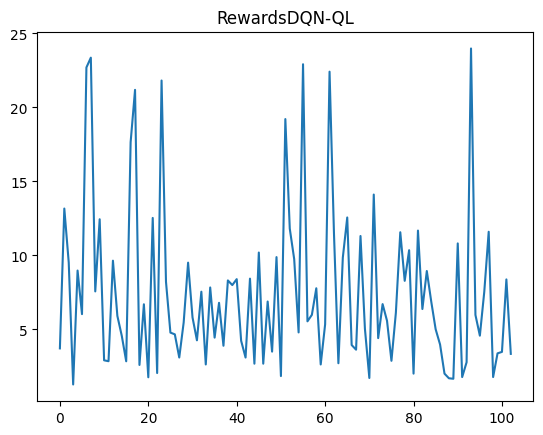

In [6]:
tot_rew=dqn.get_tot_rewards()
print(tot_rew)
plt.plot(range(len(tot_rew)), tot_rew)
plt.title("RewardsDQN-QL")

In [ ]:
dqn.train(type='SARSA')

In [ ]:
tot_rew2=dqn.get_tot_rewards()
print(tot_rew2)
plt.plot(range(len(tot_rew2)), tot_rew2)
plt.title("RewardsDQN-SARSA")

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
import os 
os.chdir('/content/drive/MyDrive')
cwd= os.getcwd()

In [9]:
!pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 34 not upgraded.
Need to get 7,697 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfontenc1 amd64 1:1.1.4-0ubuntu1 [14.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libxfont2 amd64 1:2.0.3-1 [91.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libxkbfile1 amd64 1:1.1.0-1 [65.3 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 x11-xkb-utils amd64 7.7+5 [158 kB]
Get:5 http://archive.ubuntu.com/ubunt

In [12]:
!pip install xvfbwrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5009 sha256=56cd2553e4f299f3df8ad11fe3ddfac8104a862a844e8543f8ab161089fb5a1c
  Stored in directory: /root/.cache/pip/wheels/cb/10/7d/2b7fdffccf837f7d5425931575fbee9caebe2c190931f9058b
Successfully built xvfbwrapper


In [13]:
from tqdm import trange

In [14]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gymnasium.wrappers import RecordVideo
from pathlib import Path
import base64


display = Display(visible=0, size=(1400, 900))
display.start()


def record_videos(env, video_folder="videos"):
    wrapped = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


In [15]:
env = record_videos(env,cwd)
for episode in trange(5, desc='Test episodes'):
    (obs, info), done = env.reset(), False
    while not done:
        q_values=dqn.get_prediction(obs)
        action= np.where(q_values==np.max(q_values))[0][0]
        print(action)
        obs, reward, done, truncated, info = env.step(int(action))
env.close()
show_videos(cwd)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Test episodes:   0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step
2
1/1 [==============================] - 0s 126ms/step
2
1/1 [==============================] - 0s 70ms/step
2
1/1 [==============================] - 0s 88ms/step
3


Test episodes:   0%|          | 0/5 [00:05<?, ?it/s]

Moviepy - Building video /content/drive/MyDrive/rl-video-episode-0.mp4.
Moviepy - Writing video /content/drive/MyDrive/rl-video-episode-0.mp4




Test episodes:  20%|██        | 1/5 [00:07<00:28,  7.01s/it]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rl-video-episode-0.mp4
1/1 [==============================] - 0s 92ms/step
2
1/1 [==============================] - 0s 112ms/step
2
1/1 [==============================] - 0s 123ms/step
2
1/1 [==============================] - 0s 80ms/step
1
1/1 [==============================] - 0s 97ms/step
2
1/1 [==============================] - 0s 32ms/step
2
1/1 [==============================] - 0s 37ms/step
2
1/1 [==============================] - 0s 76ms/step
2
1/1 [==============================] - 0s 45ms/step
2
1/1 [==============================] - 0s 54ms/step
2
1/1 [==============================] - 0s 33ms/step
3
1/1 [==============================] - 0s 34ms/step
3
1/1 [==============================] - 0s 33ms/step
2
1/1 [==============================] - 0s 61ms/step
1
1/1 [==============================] - 0s 122ms/step
3


Test episodes:  20%|██        | 1/5 [00:15<00:28,  7.01s/it]

Moviepy - Building video /content/drive/MyDrive/rl-video-episode-1.mp4.
Moviepy - Writing video /content/drive/MyDrive/rl-video-episode-1.mp4




Test episodes:  40%|████      | 2/5 [00:17<00:27,  9.11s/it]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rl-video-episode-1.mp4
1/1 [==============================] - 0s 55ms/step
2
1/1 [==============================] - 0s 36ms/step
1
1/1 [==============================] - 0s 85ms/step
1
1/1 [==============================] - 0s 44ms/step
3
1/1 [==============================] - 0s 42ms/step
3
1/1 [==============================] - 0s 44ms/step
1
1/1 [==============================] - 0s 42ms/step
1
1/1 [==============================] - 0s 75ms/step
1
1/1 [==============================] - 0s 121ms/step
2
1/1 [==============================] - 0s 91ms/step
2
1/1 [==============================] - 0s 209ms/step
1
1/1 [==============================] - 0s 70ms/step
1
1/1 [==============================] - 0s 95ms/step
2


Test episodes:  40%|████      | 2/5 [00:25<00:27,  9.11s/it]

Moviepy - Building video /content/drive/MyDrive/rl-video-episode-2.mp4.
Moviepy - Writing video /content/drive/MyDrive/rl-video-episode-2.mp4




Test episodes:  60%|██████    | 3/5 [00:27<00:18,  9.29s/it]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rl-video-episode-2.mp4
1/1 [==============================] - 0s 23ms/step
2
1/1 [==============================] - 0s 22ms/step
2
1/1 [==============================] - 0s 22ms/step
2
1/1 [==============================] - 0s 22ms/step
3
1/1 [==============================] - 0s 22ms/step
2
1/1 [==============================] - 0s 30ms/step
3
1/1 [==============================] - 0s 22ms/step
2


Test episodes:  60%|██████    | 3/5 [00:28<00:18,  9.29s/it]

Moviepy - Building video /content/drive/MyDrive/rl-video-episode-3.mp4.
Moviepy - Writing video /content/drive/MyDrive/rl-video-episode-3.mp4




Test episodes:  80%|████████  | 4/5 [00:29<00:06,  6.74s/it]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rl-video-episode-3.mp4
1/1 [==============================] - 0s 27ms/step
2
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 23ms/step
2
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 22ms/step
3
1/1 [==============================] - 0s 26ms/step
3
1/1 [==============================] - 0s 24ms/step
3
1/1 [==============================] - 0s 25ms/step
2


Test episodes:  80%|████████  | 4/5 [00:32<00:06,  6.74s/it]

Moviepy - Building video /content/drive/MyDrive/rl-video-episode-4.mp4.
Moviepy - Writing video /content/drive/MyDrive/rl-video-episode-4.mp4




Test episodes: 100%|██████████| 5/5 [00:32<00:00,  6.59s/it]


Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/rl-video-episode-4.mp4
